<a href="https://colab.research.google.com/github/jfdac11/DataMiningPI/blob/develop/RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####CONFIGURAÇÕES

In [ ]:
!pip install pydotplus

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from google.colab import drive

In [ ]:
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

####2020

In [ ]:
df_2020 = pd.read_csv('/content/MyDrive/Shareddrives/PI_2_2021/dobrano_2020_pre_preprocessado.csv', sep=';', low_memory=False, encoding='latin1')
df_2020.shape

(454432, 17)

In [ ]:
df_2020.head()

,idade,sexo,raca_cor,escolaridade,local_ocorrencia,teve_assistencia_medica,dia_nasc,mes_nasc,ano_nasc,dia_obito,mes_obito,ano_obito,estado,grupo_causa_basica,causa_basica,ocupacao,grupo_ocupacao
0,68.0,M,BRANCA,EF_I,DOMICILIO,NAO,10,5.0,1951.0,25,1,2020,MG,Causas mal definidas e desconhecidas de mortal...,Outras causas mal definidas e as não especific...,NaN,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...
1,53.0,M,PRETA,EF_I,DOMICILIO,NAO,16,3.0,1966.0,25,1,2020,MG,Causas mal definidas e desconhecidas de mortal...,Outras causas mal definidas e as não especific...,Trabalhador agropecuário em geral,"TRABALHADORES AGROPECUÁRIOS, FLORESTAIS E DA P..."
2,82.0,F,BRANCA,EF_I,HOSPITAL,NaN,10,7.0,1937.0,14,1,2020,MG,Outras doenças dos intestinos,"Doença diverticular do intestino, de localizaç...",NaN,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...
3,73.0,F,BRANCA,EF_I,HOSPITAL,SIM,2,11.0,1946.0,20,1,2020,MG,Outras doenças do aparelho respiratório,Insuficiência respiratória aguda,NaN,TRABALHADORES EM SERVIÇOS DE REPARAÇÃO E MANUT...
4,60.0,M,BRANCA,SUPERIOR_C,HOSPITAL,SIM,12,9.0,1959.0,26,1,2020,MG,Outras doenças bacterianas,Septicemia não especificada,Professor da educação de jovens e adultos do ...,PROFISSIONAIS DAS CIÊNCIAS E DAS ARTES ...


#### TRANSFORMANDO DADOS EM NUMÉRICOS

In [ ]:
df_2020['raca_cor'] = df_2020['raca_cor'].replace(['BRANCA', 'PRETA', 'AMARELA', 'PARDA', 'INDIGENA'], [1, 2, 3, 4, 5])

In [ ]:
df_2020['escolaridade'] = df_2020['escolaridade'].replace(
                                          ['SEM', 'EF_I', 'EF_II', 'EM', 'SUPERIOR_I', 'SUPERIOR_C', 'I'],
                                        [0, 1, 2, 3, 4, 5, 9]
                                         )

In [ ]:
df_2020['local_ocorrencia'] = df_2020['local_ocorrencia'].replace(['HOSPITAL', 'OES', 'DOMICILIO', 'VIAP', 'OUTROS', 'I'],
                                            [1, 2, 3, 4, 5, 9]
                                         )

In [ ]:
df_2020['teve_assistencia_medica'] = df_2020['teve_assistencia_medica'].replace(['SIM', 'NAO', 'I'], [1, 2, 9]
                                             )

In [ ]:
df_2020['sexo'] = df_2020['sexo'].replace(['M', 'F', 'I'], [1, 2, 0]) 

#### ORGANIZANDO DATAFRAME

In [ ]:
df_2020.shape

(454432, 15)

In [ ]:
df_2020 = df_2020[:10000]

In [ ]:
df_2020 = df_2020.loc[df_2020['grupo_causa_basica'].notnull()]

In [ ]:
df_2020.isnull().sum()

idade                         0
sexo                          0
raca_cor                    371
escolaridade                772
local_ocorrencia              0
teve_assistencia_medica    2367
dia_nasc                      0
mes_nasc                    194
ano_nasc                    194
dia_obito                     0
mes_obito                     0
ano_obito                     0
estado                        0
grupo_causa_basica            0
grupo_ocupacao             1234
dtype: int64

In [ ]:
df_2020 = df_2020.loc[df_2020.teve_assistencia_medica.notnull()]

In [ ]:
df_2020 = df_2020.loc[df_2020.raca_cor.notnull()]

In [ ]:
df_2020 = df_2020.loc[df_2020.escolaridade.notnull()]

In [ ]:
df_2020 = df_2020.loc[df_2020.mes_nasc.notnull()]

In [ ]:
df_2020 = df_2020.loc[df_2020.ano_nasc.notnull()]

In [ ]:
df_2020 = df_2020.loc[df_2020.grupo_ocupacao.notnull()]

In [ ]:
df_2020['grupo_causa_basica'] = df_2020['grupo_causa_basica'].astype('float') 

In [ ]:
df_2020['grupo_ocupacao'] = df_2020['grupo_ocupacao'].astype('float') 

In [ ]:
df_2020['grupo_ocupacao'].fillna(df_ocup_grupo.shape[0]-1)

0       9.0
1       6.0
3       9.0
4       2.0
5       7.0
       ... 
9965    6.0
9992    9.0
9994    2.0
9996    5.0
9998    9.0
Name: grupo_ocupacao, Length: 3468, dtype: float64

In [ ]:
y = df_2020['grupo_causa_basica']

In [ ]:
type(y)

pandas.core.series.Series

#### SEPARANDO TREINO E TESTE

In [ ]:
x = df_2020.drop(columns=['grupo_causa_basica'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [ ]:
x_train.shape

(2601, 14)

In [ ]:
y_test.shape

(867,)

####RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 9, random_state = 42)

In [ ]:
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
preds = rf.predict(x_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test, preds)))

69.31950498688155


In [ ]:
score = accuracy_score(y_test, preds)

In [ ]:
score

0.13494809688581316

####CONFUSION MATRIX

In [ ]:
conf_mtrx = confusion_matrix(y_test, preds)

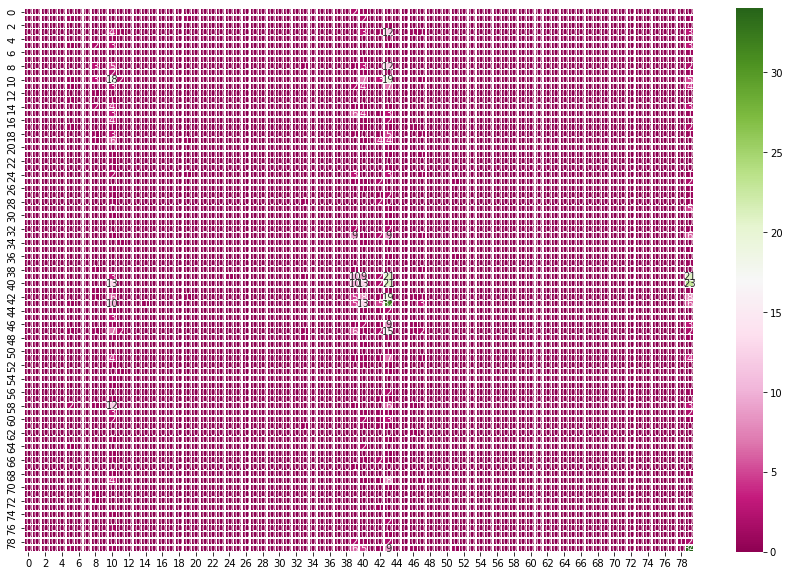

In [ ]:
plt.figure(figsize = (15, 10))
matrix = sns.heatmap(conf_mtrx, annot=True, fmt=".0f", linewidths=.5, cmap="PiYG") #Making a Heatmap out of the matrix
plt.show()

####CLASSIFICATION REPORT

In [ ]:
class_report = classification_report(y_test, preds)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(class_report)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.00      0.00      0.00         5
         2.0       0.00      0.00      0.00         1
         3.0       0.00      0.00      0.00        26
         9.0       0.00      0.00      0.00         1
        12.0       0.08      0.10      0.09        10
        15.0       0.00      0.00      0.00         1
        21.0       0.00      0.00      0.00         1
        22.0       0.15      0.11      0.13        27
        23.0       0.00      0.00      0.00         4
        24.0       0.12      0.31      0.17        59
        25.0       0.00      0.00      0.00        21
        26.0       0.00      0.00      0.00         1
        28.0       0.00      0.00      0.00         2
        30.0       0.00      0.00      0.00        12
        31.0       0.00      0.00      0.00        18
        32.0       0.00      0.00      0.00         7
        33.0       0.00    

####PLOTANDO ÁRVORE

In [ ]:
estimator = rf.estimators_[5]

In [ ]:
from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.320375 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.320375 to fit



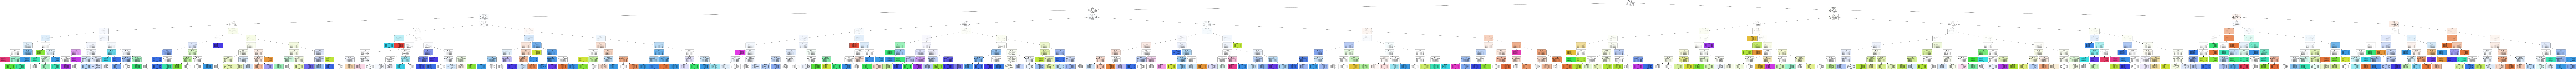

In [ ]:
dot_data = StringIO()
export_graphviz(rf.estimators_[3], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, 
                feature_names = x.columns,
                # class_names=['0','1']
                )
graph = graph_from_dot_data(dot_data.getvalue())  
graph.write_png('random_forest.png')
Image(graph.create_png())